## This notebook has been written by Rivka Zizovi and Avital Prives as a part of project in deep learning course in Semester B 2023.
Rivka Zizovi 207265711 Avital Prives 322435165

###Overview:
In this project, we chose the problem of Hebrew hand wriiten characters recognizion. The definition of the problem is that we have set of photos contains hebrew letters written in random shapes. we need to categorize every letter to its right class. The task is to build model that will learn and know how to do this.

We will work with the "Hebrew Handwritten Dataset", which is a dataset of hand written images of letters in Hebrew.

This project will focus on building machine learning model that will be trained and test in order to classify the letter in the image. We will use the CNN model. The data contains colored images of 27 classes, each class has about 200 images. The classes are classification of Hebrew letters.


# Pre processing

In [ ]:
from google.colab import drive
import os
import collections
import numpy as np
from numpy import save
from numpy import asarray
from numpy import random
import tensorflow as tf
from tensorflow import keras
from keras.utils import load_img
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import adam
from sklearn.metrics import confusion_matrix
import scipy
import seaborn as sns
from scipy.ndimage import rotate
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


For convience, we will define a dictionary that holds a mapper between class index and the meaning as a Hebrew letter name.

In [ ]:
mapper_dict = {
               0:  'Aleph',
               1:  'Bet',
               2:  'Gimel',
               3:  'Dalet',
               4:  'He',
               5:  'Vav',
               6:  'Zayin',
               7:  'Het',
               8:  'Tet',
               9:  'Yod',
               10: 'Kaf',
               11: 'Final Kaf',
               12: 'Lamed',
               13: 'Mem',
               14: 'Final Mem',
               15: 'Nun',
               16: 'Final Nun',
               17: 'Samekh',
               18: 'Ayin',
               19: 'Pe',
               20: 'Final Pe',
               21: 'Tsadi',
               22: 'Final Tsadi',
               23: 'Qof',
               24: 'Resh',
               25: 'Shin',
               26: 'Tav',
               }

Here, we have uploaded the data from the drive. Each image maned by '{class}_{serial_number}'.png.

After loading the data, we shuffeled it so that the classes wont be in acsedng order.

We created lists of images, labels - for every image in index i inside images, index i inside labels will hold the class this image categorized to. Image is stored as an array of pixels.

In [ ]:
folder_path = 'drive/MyDrive/hhd_dataset/'
photos, labels = list(), list()
lst = np.array(os.listdir(folder_path))
random.shuffle(lst)
for file in lst:
  splitted = file.split('_')
  try:
    label = int(splitted[0])
    photo = load_img(folder_path + file, target_size=(32, 32))
    photo_as_array = asarray(photo)
    photos.append(photo_as_array)
    labels.append(label)
  except:
    continue

photos = asarray(photos)
labels = asarray(labels)

For example, some records of the item set are:

And the label for the image is: Vav


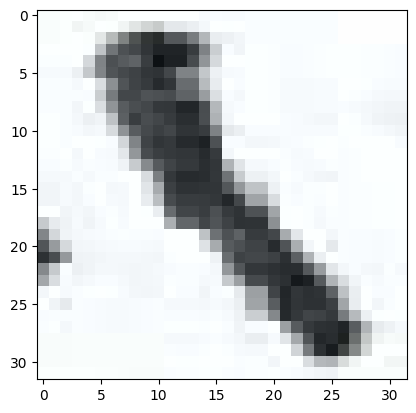

In [ ]:
plt.imshow(photos[300])
print('And the label for the image is:' , mapper_dict[labels[300]])

And the label for the image is: Zayin


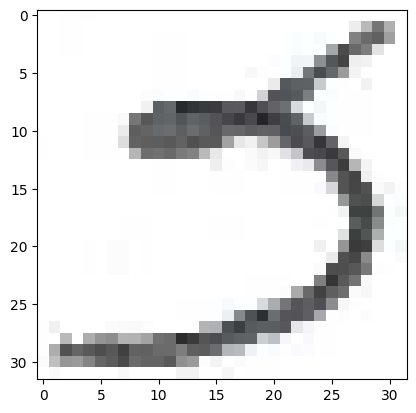

In [ ]:
plt.imshow(photos[2000])
print('And the label for the image is:' , mapper_dict[labels[2000]])

And the label for the image is: Aleph


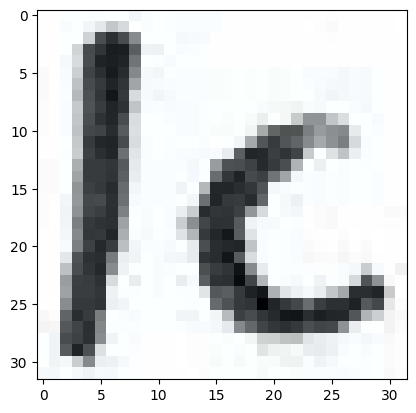

In [ ]:
plt.imshow(photos[3800])
print('And the label for the image is:' , mapper_dict[labels[3800]])

The size of the dataset:

In [ ]:
print(len(photos))
print(len(labels))

5073
5073


This is the distibution of the classes inside our data.

In [ ]:
counter = collections.Counter(labels)
list_of_keys = list(map(lambda e: (mapper_dict[e]), list(counter.keys())))
list_of_values = list(counter.values())
for i in range(len(list_of_keys)):
  print(list_of_keys[i] , ' : ', list_of_values[i])

Kaf  :  194
Final Tsadi  :  163
Pe  :  193
He  :  193
Het  :  194
Final Pe  :  167
Gimel  :  194
Aleph  :  194
Mem  :  194
Resh  :  216
Dalet  :  194
Shin  :  190
Qof  :  194
Zayin  :  194
Vav  :  194
Tsadi  :  190
Nun  :  194
Final Kaf  :  156
Final Mem  :  164
Samekh  :  192
Tet  :  194
Ayin  :  179
Bet  :  194
Yod  :  194
Final Nun  :  166
Tav  :  187
Lamed  :  195


We don't get any benefit from the image colors, that's why we decided to scale the image pixels.
We made them to be in [0, 1] range by deviding in 255.

In [ ]:
scaled_photos = photos.astype("float32") / 255
print(scaled_photos[300])

[[[0.9764706  0.99215686 0.9882353 ]
  [0.9764706  0.99215686 0.9882353 ]
  [0.9843137  1.         0.99607843]
  ...
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]]

 [[0.9764706  0.99215686 0.9882353 ]
  [0.9764706  0.99215686 0.9882353 ]
  [0.9843137  1.         0.99607843]
  ...
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]]

 [[0.9764706  0.99215686 0.9882353 ]
  [0.9764706  0.99215686 0.9882353 ]
  [0.9843137  1.         0.99607843]
  ...
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]]

 ...

 [[0.972549   0.9882353  0.9843137 ]
  [0.972549   0.9882353  0.9843137 ]
  [0.972549   0.9882353  0.9843137 ]
  ...
  [0.9882353  1.         1.        ]
  [0.9882353  1.         1.        ]
  [0.9882353  1.         1.        ]]

 [[0.972549   0.9882353  0.9843137 ]
  [0.972549   0.9882353  0.9843137 ]


# Data prepreation

In order to evaluate the model we will use a split of train and test parts from the data. The train will use for learning and the test will use for  calculations of metrics.

In addition, in order to build a successful model, we will use another part, validation set. During the learning and the training of the model, we will use the validation set to make it more accurate and improvment.
We will use the train_test_split method of sklearn library.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(photos, labels, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42) # 0.25 x 0.8 = 0.2
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')
print(X_test.shape[0], 'test samples')

3043 train samples
1015 val samples
1015 test samples


In order to work with model that classify to many optional classes, we need to represent every class as a vector of binary values, make a category value for each class.

In [ ]:
# Constants:
NUM_CLASSES = 27

In [ ]:
y_train_encoded = to_categorical(y_train, NUM_CLASSES)
y_val_encoded = to_categorical(y_val, NUM_CLASSES)
y_test_encoded = to_categorical(y_test, NUM_CLASSES)
print(y_train_encoded[300])
print(y_val_encoded[300])
print(y_train_encoded.shape[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
27


# Model selection and construction

In [ ]:
# Helper method for ploting accuracy, loss plots
def plot_loss_accuracy(history, include_val_plot):
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label = "Train Loss")
    if include_val_plot:
      ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('Cross entropy loss')
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label = "Train Accuracy")
    if include_val_plot:
      ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('Accuracy')
    ax.grid(True)

Since the dataset we decided to work with contains images, the most suitable and efficient model for dealing with such information is Convolutional Neural Network(CNN).

Instead of creating a Fully Connected NN that will contain a large number of nodes each layer, train a huge number of parameters during the training and may concentrate in specific properties of the trainingset, We can use the CNN that was built especially for dealing with images by finding the main features in the image, such as edges, angles, lines, etc.

In such a network, the chance of reaching an overfitting is much lower because it finds general features instead of specific ones.

#**MODEL1**

Here we define the model structure, number of layers, number of nodes, kernel size, input shape and activation methods.

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape = (32,32,3)),
        tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(NUM_CLASSES, activation = "softmax"),
    ]
)

We chose the loss function to be categorical crossentropy because we have 27 classes to be catagorized for.

In [ ]:
model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit(X_train, y_train_encoded,
                    batch_size = 256,
                    epochs = 25,
                    shuffle = True)

Epoch 1/25
12/12 [==============================] - 11s 33ms/step - loss: 88.1162 - accuracy: 0.0437
Epoch 2/25
12/12 [==============================] - 0s 9ms/step - loss: 5.3642 - accuracy: 0.0851
Epoch 3/25
12/12 [==============================] - 0s 8ms/step - loss: 3.0685 - accuracy: 0.1535
Epoch 4/25
12/12 [==============================] - 0s 8ms/step - loss: 2.6212 - accuracy: 0.2547
Epoch 5/25
12/12 [==============================] - 0s 7ms/step - loss: 2.5874 - accuracy: 0.3046
Epoch 6/25
12/12 [==============================] - 0s 6ms/step - loss: 1.8476 - accuracy: 0.4772
Epoch 7/25
12/12 [==============================] - 0s 7ms/step - loss: 1.6864 - accuracy: 0.5284
Epoch 8/25
12/12 [==============================] - 0s 8ms/step - loss: 1.5860 - accuracy: 0.5636
Epoch 9/25
12/12 [==============================] - 0s 7ms/step - loss: 1.2055 - accuracy: 0.6641
Epoch 10/25
12/12 [==============================] - 0s 7ms/step - loss: 1.2339 - accuracy: 0.6556
Epoch 11/25
12/1

Evaluating the model's performance.

In [ ]:
score = model.evaluate(X_test, y_test_encoded)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

32/32 [==============================] - 0s 5ms/step - loss: 2.5454 - accuracy: 0.6483
Test loss: 2.545353412628174
Test accuracy: 0.6482758522033691


Eventually, we wanted to show plot of the data during test with the accuracy and loss values.

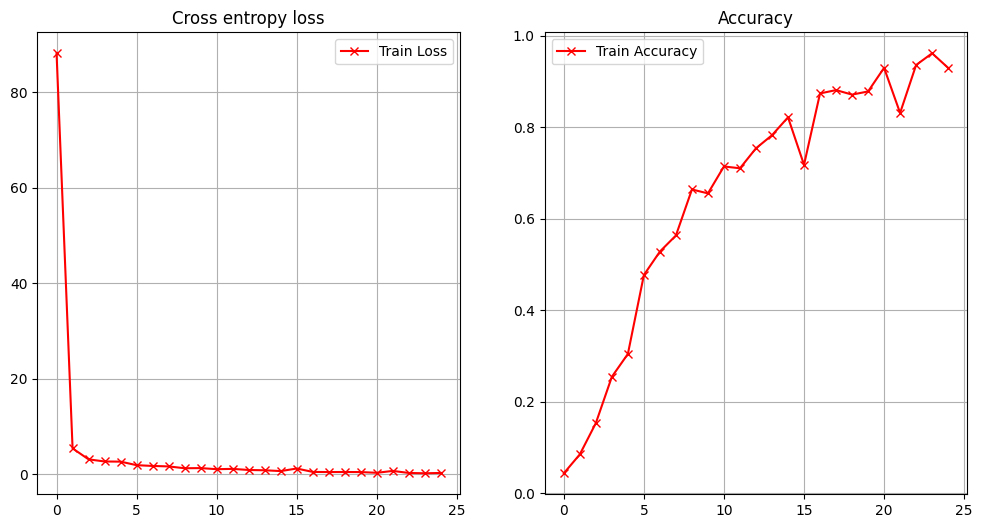

In [ ]:
plot_loss_accuracy(history, False)

From the accuracy of the training, really high, and the accuracy of the test, much lower, we can understand that this model suffers from overfitting.

We tried this model parameters because of the character of the problem. There is a similarity between our problem definition and the problem of a the MNIST dataset, identifying digits from images. That's why we chose to use the mnist model to solve this problem and adapted it to us with the hope that it will give good and high results. But it was not so.

#**MODEL2**

In order to deal with the overfitting, we tried to use regularization inside the model.
Regularization is a technique that is used to calibrate machine learning models in order to minimize the adjusted loss function and prevent overfitting or underfitting.

L2 regularization penalizes the sum of squares of the weights.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)             

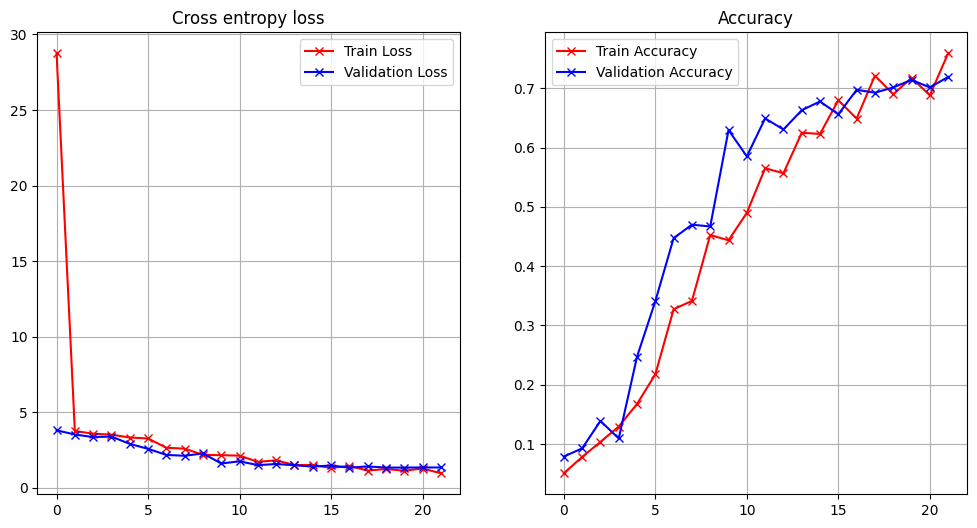

In [ ]:
model_2 = keras.Sequential(
    [
        keras.Input(shape = (32, 32, 3)),
        tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = "relu", kernel_regularizer = l2(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = "relu", kernel_regularizer = l2(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES, activation = "softmax"),
    ]
)

print(model_2.summary())

model_2.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])

epochs = 25
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True)
history_2 = model_2.fit(X_train, y_train_encoded,
                        batch_size = 256, epochs= epochs,
                        validation_data = (X_val, y_val_encoded),
                        callbacks = [early_stopping],
                       )

score_2 = model_2.evaluate(X_test, y_test_encoded)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

plot_loss_accuracy(history_2, True)

We can see that improve the overfitting but the accuracy is really low and not enough.

# **MODEL3**

We decided to give a try for a more complex model, complex architecture by more layers, nodes and use optimizer in order to icrease accuracy. We also changed the number of epochs, value of batch_size.

We used Adam as an optimizer, adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

Epoch 1/35
24/24 [==============================] - 4s 24ms/step - loss: 7.3115 - accuracy: 0.0407 - val_loss: 3.2949 - val_accuracy: 0.0729
Epoch 2/35
24/24 [==============================] - 0s 13ms/step - loss: 3.2928 - accuracy: 0.0572 - val_loss: 3.2862 - val_accuracy: 0.0463
Epoch 3/35
24/24 [==============================] - 0s 14ms/step - loss: 3.2619 - accuracy: 0.0595 - val_loss: 3.1553 - val_accuracy: 0.0906
Epoch 4/35
24/24 [==============================] - 0s 14ms/step - loss: 2.9777 - accuracy: 0.1453 - val_loss: 2.5073 - val_accuracy: 0.2906
Epoch 5/35
24/24 [==============================] - 0s 16ms/step - loss: 2.4349 - accuracy: 0.2902 - val_loss: 1.9244 - val_accuracy: 0.4128
Epoch 6/35
24/24 [==============================] - 0s 15ms/step - loss: 1.9923 - accuracy: 0.4105 - val_loss: 1.5745 - val_accuracy: 0.5113
Epoch 7/35
24/24 [==============================] - 0s 15ms/step - loss: 1.6830 - accuracy: 0.4988 - val_loss: 1.3013 - val_accuracy: 0.6246
Epoch 8/35
24

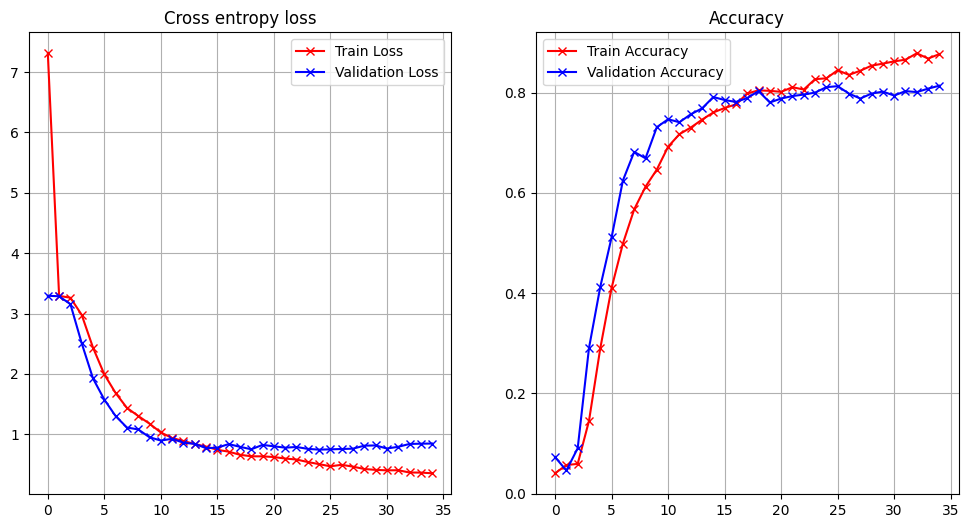

In [ ]:
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential

model_3 = Sequential()
model_3.add(Conv2D(16, (3, 3), padding = 'same', input_shape = (32, 32, 3), activation = 'relu'))
model_3.add(Conv2D(16, (3, 3), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2, 2)))
model_3.add(Dropout(0.1))
model_3.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model_3.add(Conv2D(64, (3, 3), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2, 2)))
model_3.add(Dropout(0.3))
model_3.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model_3.add(Conv2D(256, (3, 3), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2, 2)))
model_3.add(Dropout(0.5))
model_3.add(Flatten())
model_3.add(Dense(1024, activation = 'relu'))
model_3.add(Dense(512, activation = 'relu'))
model_3.add(Dense(NUM_CLASSES, activation = 'softmax'))

model_3.compile(loss = "categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

history_3 = model_3.fit(X_train, y_train_encoded,
                        batch_size = 128, epochs = 35,
                        validation_data = (X_val, y_val_encoded))

score_3 = model_3.evaluate(X_test, y_test_encoded)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])

plot_loss_accuracy(history_3, True)

The complex model gave better results.

# K Cross Validation

In order to ensure the model has no overfitting, we use k-cross validation. this process exposes the model to different subsets of the data, with the split we chose in train_teest_split, every iteration take one part of train and test add build and measure a model.
We decided to use 5 CV on model3.

In [ ]:
N_SPLIT = 5

kf = KFold(n_splits = N_SPLIT, shuffle = True, random_state = 42)

fold_no = 1
for train, test in kf.split(X_train, y_train_encoded):
  model = model_3
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no}:')

  history = model.fit(X_train, y_train_encoded, epochs = 100, verbose = 0)
  scores = model.evaluate(X_test, y_test_encoded, verbose = 0)

  print(f'Score: {model.metrics_names[0]} of {scores[0]}, and {model.metrics_names[1]} of {scores[1]*100}%')
  fold_no += 1

print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1:
Score: loss of 1.355394721031189, and accuracy of 79.40886616706848%
------------------------------------------------------------------------
Training for fold 2:
Score: loss of 1.9804480075836182, and accuracy of 78.52216958999634%
------------------------------------------------------------------------
Training for fold 3:
Score: loss of 2.0991673469543457, and accuracy of 78.22660207748413%
------------------------------------------------------------------------
Training for fold 4:
Score: loss of 1.9743279218673706, and accuracy of 78.02955508232117%
------------------------------------------------------------------------
Training for fold 5:
Score: loss of 1.9347190856933594, and accuracy of 77.24137902259827%
------------------------------------------------------------------------


We can see that every iteration built a model with a same size of accuracy and loss values, so we can say that this model isn't suffering from overfitting.

# Data augmentation

Data augmentation is a process of artificially increasing the amount of data by generating new data points from existing data. It can be done by  flipping, translation, rotation, or the addition of noise on the data in order to increase the diversity of the training set.

We tried to use augmentation in order to increase the data set and then maybe get better results.

In [ ]:
datagen = ImageDataGenerator(
   rotation_range = 5,
   width_shift_range = 0.1,
   height_shift_range = 0.1,
   zoom_range = 0.1
)

datagen.fit(X_train)

model_3.fit(x = datagen.flow(X_train, y_train_encoded, batch_size = 128),
            validation_data = (X_val, y_val_encoded),
            steps_per_epoch = len(X_train) // 128,
            epochs = 35)

score_3_aug = model_3.evaluate(X_test, y_test_encoded)
print('Test loss:', score_3_aug[0])
print('Test accuracy:', score_3_aug[1])

Epoch 1/35
23/23 [==============================] - 2s 94ms/step - loss: 0.3586 - accuracy: 0.8799 - val_loss: 0.8243 - val_accuracy: 0.8207
Epoch 2/35
23/23 [==============================] - 3s 125ms/step - loss: 0.3440 - accuracy: 0.8799 - val_loss: 0.7679 - val_accuracy: 0.8246
Epoch 3/35
23/23 [==============================] - 2s 77ms/step - loss: 0.3540 - accuracy: 0.8787 - val_loss: 0.7463 - val_accuracy: 0.8227
Epoch 4/35
23/23 [==============================] - 2s 78ms/step - loss: 0.3571 - accuracy: 0.8813 - val_loss: 0.7717 - val_accuracy: 0.8128
Epoch 5/35
23/23 [==============================] - 2s 78ms/step - loss: 0.3630 - accuracy: 0.8744 - val_loss: 0.7813 - val_accuracy: 0.8236
Epoch 6/35
23/23 [==============================] - 3s 112ms/step - loss: 0.3665 - accuracy: 0.8765 - val_loss: 0.7397 - val_accuracy: 0.8197
Epoch 7/35
23/23 [==============================] - 3s 116ms/step - loss: 0.3222 - accuracy: 0.8930 - val_loss: 0.7862 - val_accuracy: 0.8296
Epoch 8/35

The augmentation helped a little more and increased the resuts.

# Transfer Learning

Transfer learning is a technique in machine learning in which knowledge learned from a task is re-used in order to boost performance on a related task.
We tried to take pre trained Resnet network and fit it to our data.


Resnet identifies  shortcut connection, which allows the model to skip one or more layers. This approach makes it possible to train the network on thousands of layers without affecting performance.

Epoch 1/35
24/24 [==============================] - 141s 407ms/step - loss: 2.7076 - accuracy: 0.2718 - val_loss: 510550.9062 - val_accuracy: 0.0394
Epoch 2/35
24/24 [==============================] - 4s 169ms/step - loss: 1.5541 - accuracy: 0.5984 - val_loss: 1695497.3750 - val_accuracy: 0.0433
Epoch 3/35
24/24 [==============================] - 4s 149ms/step - loss: 1.0862 - accuracy: 0.7144 - val_loss: 7877.4673 - val_accuracy: 0.0335
Epoch 4/35
24/24 [==============================] - 4s 150ms/step - loss: 0.8489 - accuracy: 0.7749 - val_loss: 37012.0078 - val_accuracy: 0.0966
Epoch 5/35
24/24 [==============================] - 5s 232ms/step - loss: 0.7279 - accuracy: 0.8051 - val_loss: 383.3447 - val_accuracy: 0.4719
Epoch 6/35
24/24 [==============================] - 4s 150ms/step - loss: 0.6730 - accuracy: 0.8219 - val_loss: 313.2401 - val_accuracy: 0.4483
Epoch 7/35
24/24 [==============================] - 4s 152ms/step - loss: 0.6371 - accuracy: 0.8265 - val_loss: 3.2680 - val

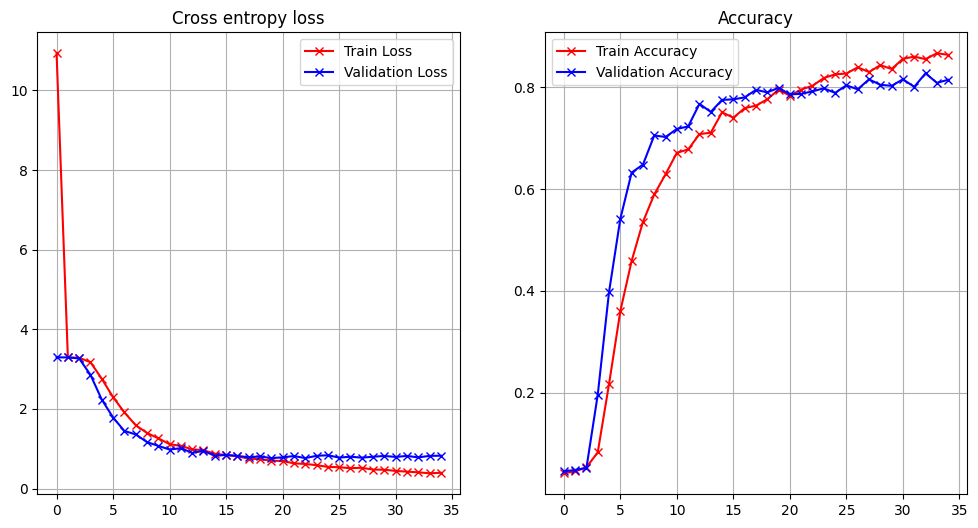

In [ ]:
transfer_model = Sequential()

transfer_model.add(keras.applications.ResNet152(
                    input_shape = (32, 32, 3),
                    include_top = False, weights = 'imagenet'))
transfer_model.add(Dense(1024, activation="relu"))
transfer_model.add(Dense(512, activation = 'relu'))
transfer_model.add(Flatten())
transfer_model.add(Dense(256, activation = 'relu'))
transfer_model.add(Dense(64, activation = 'relu'))
transfer_model.add(Dense(NUM_CLASSES, activation = 'softmax'))

transfer_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
                       loss = 'categorical_crossentropy', metrics = ['accuracy'])

for layer in transfer_model.layers[0].layers:
  if layer.name == 'conv5_block1_0_conv':
    break
  layer.trainable=False

transfer_history_3 = transfer_model.fit(X_train, y_train_encoded,
                                        batch_size = 128, epochs = 35,
                                        validation_data = (X_val, y_val_encoded))

transfer_model_score = transfer_model.evaluate(X_test, y_test_encoded)
print('Test loss:', transfer_model_score[0])
print('Test accuracy:', transfer_model_score[1])

plot_loss_accuracy(history_3, True)

The transfer model didn't give really good results. It can be as a result of a model train that has been done on different kind of data. because of the size of our data(really small) and that it specific, the model may not be able reach higher results.

# Conclusions


We have built a model that knows how to categorized images that contain Hebrew hand written letters with accuracy of 83 percent.
The dataset is really small and this is the best metrics we could have reached using the techniques we have learned.

MNIST dataset is has has similarities to ours, but our assumption is that its good results related to its size.
Maybe there are more ways to increase the model performance but under this project, this is the work has been done.